# Modeling the Representation of Speech in the Brain
Originally given as a tutorial at EACL 2014 by Alex Huth.

In this tutorial you will step through a voxel-wise modeling analysis. You will use computational models to extract semantic features from a natural speech stimulus. Then these features will be used to build linear models of fMRI data, and model weights and prediction performance will be visualized.

If you so desire, you can step through this entire tutorial without modifying any code. But there are a few points where you will be able to make simply modifications and then see what effect those modifications have on the results. Additionally at the end you can re-run the model using phoneme features instead of semantic features.

#### Acknowledgements
This fMRI data used in this tutorial was collected by Alex Huth and Wendy de Heer at the University of California, Berkeley. All work was supervised by professors Jack Gallant and Frederic Theunissen of the UC Berkeley Psychology Department. Please do not redistribute the code or data used here. Visualization is done using [pycortex](http://pycortex.org).

#### Citation
The analysis demonstrated in this tutorial forms the basis of this paper:
[Huth, A. G. et al., "Natural speech reveals the semantic maps that tile human cerebral cortex" (2016) _Nature_.](https://www.nature.com/articles/nature17637)

## The experiment
In this experiment a subject underwent fMRI scanning while they listened to roughly 2 hours of natural narrative speech stimuli. These stimuli were 10-15 minute complete stories drawn from *The Moth Radio Hour*, a radio program where storytellers tell true, autobiographical stories in front of a live audience.

## This notebook
This notebook is written in python, and is presented using the iPython notebook. **To evaluate a block of code, click in it to select it, and then press shift-Enter.** You can go through the entire tutorial (until the optional section at the end) by just running each block in turn. But you'll learn more if you stop and mess around with each block as you go.

* If you're totally new to python, you might check out this collection of [simple python programs](https://wiki.python.org/moin/SimplePrograms), which is a very quick intro to python's syntax and data structures. You can also find dozens of python beginner's guides on the internet.
* If you're new to python but know MATLAB, check out [this reference](http://wiki.scipy.org/NumPy_for_Matlab_Users). It has python/numpy equivalents for most common MATLAB functions.
* Plotting is accomplished here using matplotlib, a MATLAB-like plotting library for python. If you want to learn more about the basics of using matplotlib, check out [this notebook](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb).
* Finally, there are a number of points where the notebook imports libraries that I (Alex) have written. If you want to see the code for this, create a new cell (use the menu item `Insert > Insert cell below`), enter `%load libraryname.py`, and evaluate.

In [10]:
# Run this cell if your computer has a 'retina' or high DPI display. It will make the figures look much nicer.
# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [11]:
# This cell imports libraries that you will need
# Run this.
from matplotlib.pyplot import figure, cm
import numpy as np
import logging
logging.basicConfig(level=logging.DEBUG)

## The semantic model: English1000
Here you will load a precomputed vector-space semantic model. This semantic model will transform any word (well, any word it knows about) into a 985-dimensional vector. This 985-dimensional semantic space has the nice property that words that are close together tend to have similar meanings. Although it would have been fun to have tried reconstructing this semantic model in this tutorial, it takes a really long time and it doesn't seem like the parameters matter that much. So today you're just going to work with the preconstructed semantic model.

The semantic model was constructed using a decently large corpus of text (a couple billion words, comprising the stories used as stimuli here, 604 popular books, 2,405,569 wikipedia pages, and 36,333,459 user comments scraped from reddit.com) and a lexicon of roughly 10,000 words. We selected 985 "basis words" from the Wikipedia "List of 1000 basic words" (contrary to the title, this lost does not actually contain 1000 words, but this is where the title of the model comes from). These are common words that span many topics.

We constructed a word co-occurrence matrix, $M$, with 985 rows and 10,470 columns. Iterating through the training corpus, we added 1 to $M_{ij}$ each time word $j$ appeared within 15 words of basis word $i$. The window size of 15 was selected to be large enough to suppress syntactic effects (word order) but no larger. Once the co-occurrence matrix was complete, we log transformed the counts, replacing $M_{ij}$ with $\log(1 + M_{ij})$. Then each row of M was z-scored to correct for differences in basis word frequency, and finally each column of $M$ was z-scored to correct for word frequency. The resulting matrix is the one you're loading here.

(As an aside, while I constructed this model in a totally ad hoc and unplanned way, it has properties that are very similar to Mikolov's [word2vec model](https://code.google.com/p/word2vec/) that's recently gained a lot of popularity.)

Anyway, here you are going to load the model and then play with it a bit to see how it works.

In [12]:
# Load semantic model
# The SemanticModel class is something I wrote to make it easy to deal with vector-space semantic models.
from SemanticModel import SemanticModel
eng1000 = SemanticModel.load("data/english1000sm.hf5")

DEBUG:SemanticModel:Loading file: data/english1000sm.hf5
DEBUG:SemanticModel:Done loading file..


In [13]:
# You can get the vector for a word by indexing the model with that word
# For example, the vector for "finger":
print(eng1000["finger"])

[-3.01957543e-02 -1.58815208e-01  3.72586468e-01  6.31520216e-01
 -5.41207327e-01 -1.47432759e+00 -1.05915070e+00 -4.16644800e-01
  1.20502323e-01 -5.15060363e-01  1.23904878e-01 -9.33992565e-01
 -1.05883262e-01 -5.79853435e-01  2.94983034e-02 -2.43542920e-01
 -5.92298265e-01  6.90182885e-02 -5.13458809e-01  1.53945791e-01
 -2.98635717e-01 -1.76474347e-01 -5.17992699e-01 -2.67308837e-01
  5.05877087e-01 -9.80404899e-02 -4.44428154e-02 -3.05776285e-01
  2.97729455e-01  2.37905694e-01 -1.88648910e-01 -3.17506290e-01
 -5.33254593e-01 -7.07116002e-01  2.54096127e+00 -1.84512793e+00
  6.68122823e-01 -3.54202630e-01 -6.79908010e-01 -5.19517465e-01
  2.52528273e-01  1.00967376e-01 -7.86818600e-01  1.75987727e-01
 -2.20915266e+00  2.79098918e-01  6.21732275e-01  6.84270165e-01
  2.10828246e-01  9.80781382e-01  1.50115083e+00 -1.05500410e+00
  3.13293716e-01  5.32585620e-01 -2.91568208e-01 -4.38885716e-01
  1.10569814e+00 -1.87596079e-01  4.91572934e-01  6.95940502e-02
  6.46628909e-01 -1.92923

### Visualizing a word
First let's plot the length 985 vector for one word to see what it looks like.

Text(0,0.5,'Feature value')

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


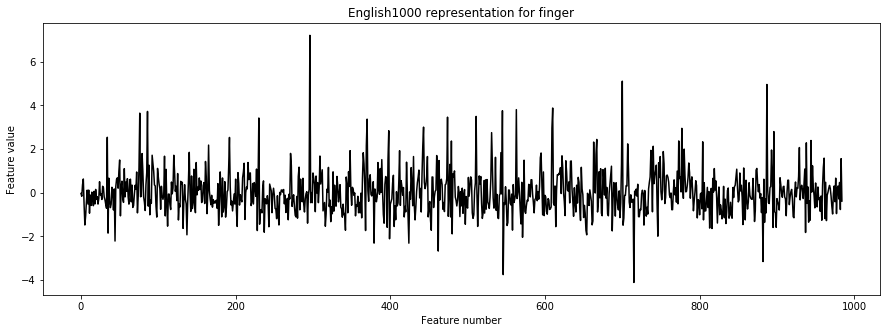

In [14]:
plot_word = "finger"

f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(eng1000[plot_word], 'k')
ax.axis("tight")
ax.set_title("English1000 representation for %s" % plot_word)
ax.set_xlabel("Feature number")
ax.set_ylabel("Feature value")

### Visualizing more than one word
Next let's plot the vectors for three words: "finger", "fingers", and "grief". Here you will see that "finger" (in black) and "fingers" (in red) look very similar, but "grief" (in blue) looks very different. Neat.

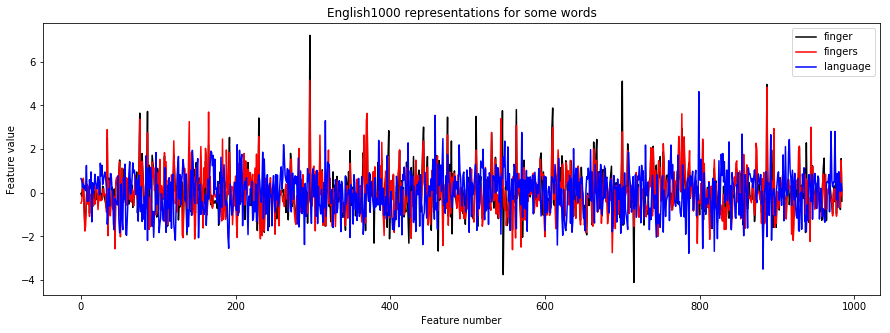

In [15]:
plot_words = ["finger", "fingers", "language"]
colors = ["k", "r", "b"]

f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
wordlines = []

for word, color in zip(plot_words, colors):
    wordlines.append(ax.plot(eng1000[word], color)[0])

ax.axis("tight")
ax.set_title("English1000 representations for some words")
ax.set_xlabel("Feature number")
ax.set_ylabel("Feature value")
ax.legend(wordlines, plot_words)

### Semantic smoothness
One nice test of a vector-space semantic model is whether it results in a "semantically smooth" representation of the words. That is, do nearby words in the space have intuitively similar meanings? Here you can test that using the method `find_words_like_word`. 

Give any word (that the model knows about), and it will print out the 10 closest words (that it knows about) and their cosine similarities (or correlations, same thing in this case). This includes the word you supplied.

In this next example it prints the closest words to "finger". All of the 10 closest words are semantically related: 9 are nouns, and 1 is a verb ("stick"; of course this is also a noun, I'm just assuming that the sense of "stick" that's close to "finger" is probably the verb sense, but this brings up an important point: this model does nothing to disambiguate between different word senses!).

You can put different words in here and see what the model comes up with. 

*(Be warned: the model knows some dirty words. It was trained using the internet, after all.)*

In [16]:
# Test semantic model
eng1000.find_words_like_word("finger")

[(1.0, 'finger'),
 (0.8152045140028775, 'fingers'),
 (0.6747595355473319, 'hand'),
 (0.6745201474550795, 'nose'),
 (0.6618110335849765, 'arm'),
 (0.6485988426371899, 'mouth'),
 (0.6477021326212881, 'stick'),
 (0.6382432365355891, 'neck'),
 (0.6358168681236416, 'forehead'),
 (0.6256921294162918, 'tongue')]

Here is just another example, but this one an abstract noun, "language". Again the model does a pretty good job at finding related words.

In [17]:
eng1000.find_words_like_word("language")

[(1.0, 'language'),
 (0.8560080667907979, 'languages'),
 (0.6499251700967128, 'understanding'),
 (0.625484944595069, 'philosophy'),
 (0.6233664577929341, 'learning'),
 (0.6222707763330103, 'ideas'),
 (0.6214787276220987, 'philosophical'),
 (0.6177845454632057, 'expressions'),
 (0.6156760397365072, 'subject'),
 (0.6124065941494572, 'interpretation')]

In [18]:
eng1000.find_words_like_vec(eng1000["king"] - eng1000["man"] + eng1000["woman"])

[(0.8110762236714161, 'king'),
 (0.7535193223645593, 'queen'),
 (0.7444733550430283, 'prince'),
 (0.6961617552766914, 'elizabeth'),
 (0.6959339192996905, "king's"),
 (0.6805987225252264, 'maria'),
 (0.6744722873814399, 'princess'),
 (0.673777608907728, 'duke'),
 (0.6661078636656457, 'sons'),
 (0.66490508180503, 'eldest')]

## The stimuli: Moth stories
Next we're going to load up the stimuli. We're not going to be dealing with the actual audio of the stories that were presented, but instead with aligned transcripts. These were generated using the UPenn forced aligner (P2FA), which figures out when each word was spoken given the transcript and the audio. The transcripts are stored in TextGrid format (native to Praat), which can be loaded directly into Python using some code from the natural language toolkit (NLTK).

Here you will load the TextGrids for the stories, as well as 'TRfiles', which specify the time points relative to story onset when the fMRI data was collected (roughly every 2 seconds).

Finally the TextGrids and TRfiles will be combined together into a representation I call a DataSequence. There is nothing interesting going on here scientifically, this is just something to make subsequent steps more manageable.

In [19]:
# These are lists of the stories
# Rstories are the names of the training (or Regression) stories, which we will use to fit our models
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 
            'life', 'myfirstdaywiththeyankees', 'naked', 
            'odetostepfather', 'souls', 'undertheinfluence']

# Pstories are the test (or Prediction) stories (well, story), which we will use to test our models
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

# Load TextGrids
from stimulus_utils import load_grids_for_stories
grids = load_grids_for_stories(allstories)

# Load TRfiles
from stimulus_utils import load_generic_trfiles
trfiles = load_generic_trfiles(allstories)

# Make word and phoneme datasequences
from dsutils import make_word_ds, make_phoneme_ds
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}

Before going on, let's play with the DataSequences a bit, both so you can see what the data structure looks like, and also so you can see what the stimuli look like.

In [20]:
naked = wordseqs["naked"]
# The DataSequence stores a lot of information
# naked.data is a list of all the words in the story
print ("There are %d words in the story called 'naked'" % len(list(naked.data)))

There are 3218 words in the story called 'naked'


In [21]:
# We can print out the first 100 words like this
print (list(naked.data)[:100])

['i', 'grew', 'up', 'in', 'a', 'really', 'small', 'town', 'in', 'alabama', 'and', 'my', 'sister', 'was', 'and', 'is', 'to', 'this', 'day', 'a', 'remarkably', 'beautiful', 'woman', 'and', 'i', 'was', 'always', 'really', 'good', 'in', 'school', 'so', 'it', 'fell', 'into', 'this', 'pattern', 'with', 'my', 'family', 'where', 'people', 'would', 'say', 'things', 'like', "she's", 'the', 'beauty', "you're", 'the', 'brain', 'and', 'among', 'my', 'almost', 'anorexically', 'petite', 'friends', 'growing', 'up', 'at', 'five', 'foot', 'five', 'a', 'hundred', 'and', 'forty', 'pounds', 'it', 'was', 'universally', 'acknowledged', 'that', 'i', 'was', 'the', 'fat', 'one', 'the', 'whole', 'thing', 'really', 'started', 'in', 'first', 'grade', 'i', 'have', 'to', 'say', 'there', 'was', 'a', 'weigh', 'in', 'in', 'school', 'my']


In [22]:
# or, if you want it to be more readable, like this
print (" ".join(list(naked.data)[:100]))

i grew up in a really small town in alabama and my sister was and is to this day a remarkably beautiful woman and i was always really good in school so it fell into this pattern with my family where people would say things like she's the beauty you're the brain and among my almost anorexically petite friends growing up at five foot five a hundred and forty pounds it was universally acknowledged that i was the fat one the whole thing really started in first grade i have to say there was a weigh in in school my


In [23]:
# the datasequence also stores when exactly each word was spoken (this time corresponds to the middle of each word)
print (naked.data_times[:10])

[0.19705215 0.38662132 0.59614512 0.75675316 0.85153774 1.02517007
 1.32947846 1.6537415  1.84829932 2.19251701]


In [24]:
# and it also stores the time of the middle of each fMRI acquisition (each acqusition takes 2.0045 seconds)
# these times are relative to story start, so the fMRI scan started 10 seconds before the story
print (naked.tr_times[:10])

[-9.02085041 -7.04012641 -5.03223841 -3.03203841 -1.02396941  0.98489959
  2.98378359  4.99206359  6.99189259  8.99996159]


In [25]:
# and it also makes it easy to, for example, find the words that were spoken during each fMRI acquisition
# (the first few are empty because they came before the story started)
print (naked.chunks()[:10])

[array([], dtype='<U15'), array([], dtype='<U15'), array([], dtype='<U15'), array([], dtype='<U15'), array([], dtype='<U15'), array(['i', 'grew', 'up', 'in', 'a', 'really', 'small', 'town', 'in',
       'alabama'], dtype='<U15'), array(['and', 'my', 'sister'], dtype='<U15'), array(['was', 'and', 'is', 'to', 'this', 'day', 'a', 'remarkably'],
      dtype='<U15'), array(['beautiful', 'woman', 'and', 'i', 'was', 'always'], dtype='<U15'), array(['really', 'good', 'in', 'school'], dtype='<U15')]


## Projecting the stimuli into the semantic space
The next step in this analysis is that you need to project each word in the stimulus into the English1000 semantic feature space that you loaded above. I wrote a nice function to do this called `make_semantic_model` that simply takes the word DataSequence and the semantic model, and spits out a new DataSequence where each word is replaced by a 985-dimensional vector.

In [26]:
# Project stimuli
from dsutils import make_semantic_model
semanticseqs = dict() # dictionary to hold projected stimuli {story name : projected DataSequence}
for story in allstories:
    semanticseqs[story] = make_semantic_model(wordseqs[story], eng1000)

In [27]:
# take a look at the projected stimuli
naked_proj = semanticseqs["naked"]

print (naked_proj.data.shape) # prints the shape of 'data' as (rows, columns)
print (naked_proj.data[:10]) # print the first 10 rows (this will be truncated)

(3218, 985)
[[-0.48074415  0.10393176 -0.45596143 ... -0.03175243 -0.62248756
  -0.32170921]
 [ 0.09911849  0.06500191 -0.78847992 ...  1.95413789 -0.94043714
  -1.0863888 ]
 [-0.73058513 -0.37099858 -0.59858174 ... -0.30655477 -0.30774183
  -0.66815734]
 ...
 [ 0.59646679  0.31843488  0.78981277 ...  0.21670864 -1.09263289
  -1.26290446]
 [-0.61541241 -1.1005762  -0.33248156 ...  0.23637707 -1.5470721
  -0.6521566 ]
 [ 0.3866531  -0.05810349 -0.63087673 ...  0.43836955 -1.03314247
  -0.57172974]]


### Downsample the projected stimuli
In order to build a model, you need to downsample the semantic representations of the stimuli to the same temporal scale as the fMRI responses that you will be modeling. The DataSequence provides a method that does this, called `chunksums`.

For those of you who are interested, downsampling is accomplished here using a 3-lobe Lanczos filter (see [here](http://en.wikipedia.org/wiki/Lanczos_window) for details about the math). You can try changing the number of lobes, it shouldn't affect the results much.

In [31]:
# Downsample stimuli
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_semanticseqs[story] = semanticseqs[story].chunksums(interptype, window=window)


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


### Visualizing the downsampling
Next you're going to visualize what the downsampling did. Here you're going to plot the value of one semantic feature (feature 2, which is actually the third feature: zero-based indexing) for each word, and also the downsampled vector.

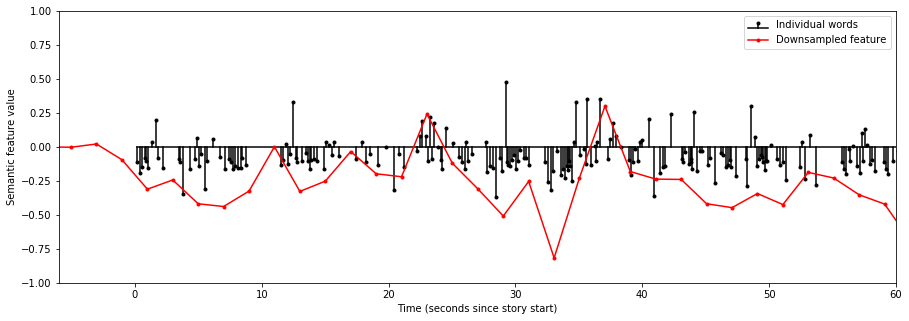

In [32]:
# Plot the result
s_words = wordseqs["naked"]
s_sem = semanticseqs["naked"]
s_semdown = downsampled_semanticseqs["naked"]

f = figure(figsize=(15,5))
f.clf()
schan = 2
ax = f.add_subplot(1,1,1)
wordstems = ax.stem(s_sem.data_times, 
                    s_sem.data[:,schan] / np.abs(s_sem.data[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(s_sem.tr_times, 
                  s_semdown[:,schan] / np.abs(s_semdown[:,schan]).max(), 'r.-')
ax.set_xlim(-6, 60)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (seconds since story start)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));

### Concatenating features across stories
Next you're going to combine together all the features from all the stories into one big matrix. Within this operation, you're also going to [z-score](http://en.wikipedia.org/wiki/Z-score) each feature within each story. This operation subtracts off the mean and then divides by the standard deviation. This might seem like a weird or incomprehensible thing to do, but I do it because the responses to each story are z-scored individually. Anyway not a big deal.

The features for each story are also trimmed a bit (the variable `trim` determines how many time points are removed from the beginning and end of each story). The fMRI responses at the beginnings and ends of the stories are often noisier than at other times because of transients and problems with detrending (an fMRI preprocessing step that you don't need to worry about here aside from this point).

The combined features are stored in big matrices called `Rstim` (with the training, or Regression stimuli) and `Pstim` (with the test, or Prediction stimuli).

In [33]:
# Combine stimuli
from npp import zscore
trim = 5
Rstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories])
Pstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Pstories])


In [34]:
storylens = [len(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories]
print(storylens)

print(np.cumsum(storylens))

[343, 367, 354, 400, 430, 358, 422, 404, 355, 304]
[ 343  710 1064 1464 1894 2252 2674 3078 3433 3737]


In [35]:
# Print the sizes of these matrices
print ("Rstim shape: ", Rstim.shape)
print ("Pstim shape: ", Pstim.shape)

Rstim shape:  (3737, 985)
Pstim shape:  (291, 985)


### Visualizing the combined stimuli
Next you're going to plot some of the feature channels. This is just to see what the feature look like that are going to go into the regression model.

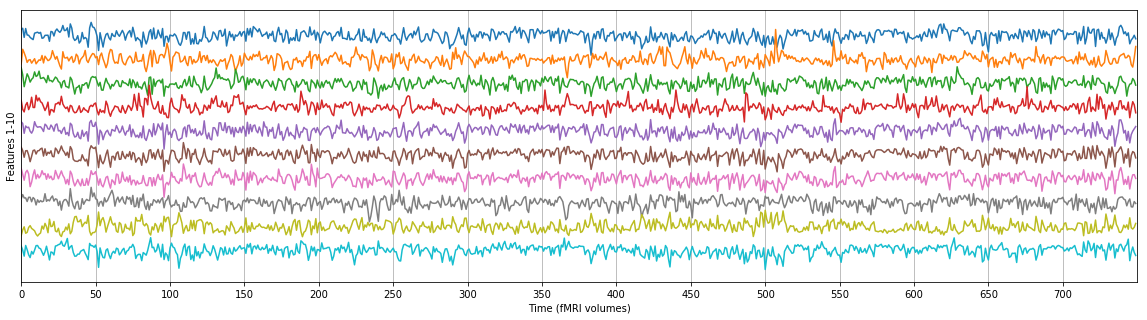

In [36]:
# Plot some of the combined stimuli
f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(10):
    # Plot each feature, offset by 5 vertically so they are easier to see
    ax.plot(Rstim[:750,ii] - 5 * ii)

ax.set_xlim(0, 750)
ax.set_yticks([])
ax.set_xticks(range(0, 750, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

### Concatenate delayed stimuli for FIR model
Next you are going to concatenate multiple delayed versions of the stimuli, in order to create a linear [finite impulse response (FIR) model](http://en.wikipedia.org/wiki/Fir_filter). This is a vitally important step, and is conceptually a bit difficult, so take a few minutes to make sure you understand what is going on here.

#### Background: the hemodynamic response
First you need to understand the problem that the FIR model is solving. fMRI measures the blood-oxygen level dependent (BOLD) signal, which is a complicated and nonlinear combination of blood oxygenation and blood volume. When neurons in an area of the brain become active, they start using up lots of energy. To compensate, nearby blood vessels dilate so that more oxygen and glucose become available to the neurons. The resulting changes in blood oxygenation (which increases) and volume (which also increases) create the magnetic signature that is recorded by fMRI. 

But this process is **slow**. It takes seconds after the neural activity begins for the blood vessels to dilate and for the BOLD response to become apparent. And then it takes more seconds for the response to go away. So although a neural response might only last milliseconds, the associated BOLD response will rise and fall over a span of maybe 10 seconds, orders of magnitude slower. The shape of this rise and fall is called the [hemodynamic response function (HRF)](http://en.wikipedia.org/wiki/Haemodynamic_response).

Here is a pretty standard looking example of an HRF:

<img src='http://www.brainmatters.nl/wp-content/uploads/bold.png' width=350px></img>

#### FIR model
To accurately model how the brain responds to these stimuli we must also model the HRF. There are many ways to do this. The most common is to assume that the HRF follows a canonical shape. But this approach turns out to not work very well: different parts of the brain have very different vasculature (blood vessels), so the HRF shape can vary a lot. 

Instead, what you are going to here is estimate a separate HRF for each semantic feature in each voxel that is being modeled. This estimate is going to take the form of a linear finite impulse response (FIR) model. The linear FIR form is particularly nice to use because it's very simple to estimate and powerful (if anything, it might be too powerful.. more on that later). To build a linear FIR model all you have to do is concatenate together multiple delayed copies of the stimulus. I usually use four delays: 1, 2, 3, and 4 time points. The resulting delayed features can be thought of as representing the stimulus 1, 2, 3, and 4 time points ago. So the regression weights for those features will represent how a particular voxel responds to a feature 1, 2, 3, or 4 time points in the past, and these regression weights are a 4-point estimate of the HRF for that feature in that voxel.

The potential downside of the FIR model is that it may be too expressive. Each feature in each voxel is allowed to have any HRF, but this comes at the cost of multiplying the total number of regression weights that we must fit by the number of delays. In all likelihood the true HRFs vary, but they don't vary that much, so we probably don't need this many independent features. This cost becomes apparent if you increase the number of delays. This will slow down model fitting and likely decrease the stability of the regression weights, leading to decreased model performance. 

Feel free to play around with the number of delays and see how it affects the model results!

In [37]:
# Delay stimuli
from util import make_delayed
ndelays = 4
delays = range(1, ndelays+1)

print ("FIR model delays: ", delays)

delRstim = make_delayed(Rstim, delays)
delPstim = make_delayed(Pstim, delays)


FIR model delays:  range(1, 5)


In [38]:
# Print the sizes of these matrices
print ("delRstim shape: ", delRstim.shape)
print ("delPstim shape: ", delPstim.shape)

delRstim shape:  (3737, 3940)
delPstim shape:  (291, 3940)


### Visualizing FIR features
Here you will visualize the first semantic feature at each of the delays.

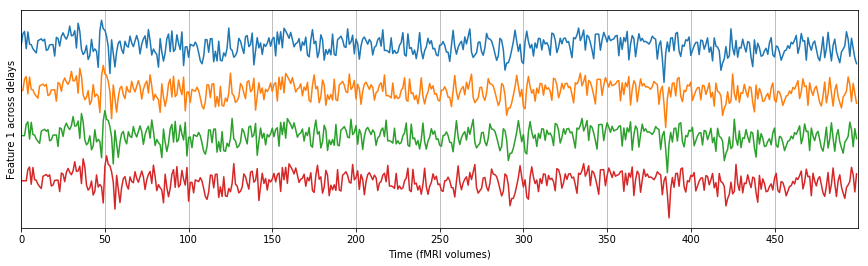

In [39]:
# Plot the same feature at different delays
f = figure(figsize=(15, 4))
ax = f.add_subplot(1,1,1)
for ii in range(ndelays):
    ax.plot(delRstim[:500, ii * Rstim.shape[1]] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Feature 1 across delays")
ax.grid()

## Response data
Next you will load the fMRI data. This is totally the most exciting part! These responses have already been preprocessed (the 3D images were motion corrected and aligned to each other, detrended, and then z-scored within each stimulus) so you don't have to worry about that.

You will load three different variables: `zRresp`, the responses to the regression dataset; `zPresp`, the responses to the prediction dataset; and `mask`, which is a 3D mask showing which voxels have been selected (we are not modeling every voxel in the scan, that would take forever, we are only modeling the voxels that overlap with the cerebral cortex).

In [77]:
# Load responses
import tables
resptf = tables.open_file("data/fmri-responses.hf5")
zRresp = resptf.root.zRresp.read()
zPresp = resptf.root.zPresp.read()
mask = resptf.root.mask.read()

In [41]:
# Print matrix shapes
print ("zRresp shape (num time points, num voxels): ", zRresp.shape)
print ("zPresp shape (num time points, num voxels): ", zPresp.shape)
print ("mask shape (Z, Y, X): ", mask.shape)

zRresp shape (num time points, num voxels):  (3737, 37226)
zPresp shape (num time points, num voxels):  (291, 37226)
mask shape (Z, Y, X):  (31, 100, 100)


In [81]:
np.save('../../data/brains/mask.npy', mask)

### Visualize where the voxels are coming from (mask)
Next you will visualize where the voxels are coming from in the brain. This will give you an idea of where the data come from.

First you will plot a single slice through the mask in the Z dimension. This is called an "axial" slice. The top of the image is the front of the brain, the bottom is the back. The left side of the image is the right side of the brain, and the right side of the image is the left side of the brain (as if you are looking up at the brain from under the subject's chin; this left-right reversal is often referred to as "radiological coordinates", as opposed to "neurological coordinates" where you are looking down from the top).

Then you will plot a mosaic of all the slices. This is done using the function `mosaic` from James Gao's pyCortex package.

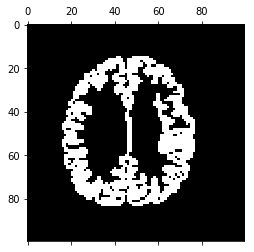

In [42]:
# Plot one slice of the mask that was used to select the voxels
f = figure()
ax = f.add_subplot(1,1,1)
ax.matshow(mask[16], interpolation="nearest", cmap=cm.gray) # show the 17th slice of the mask

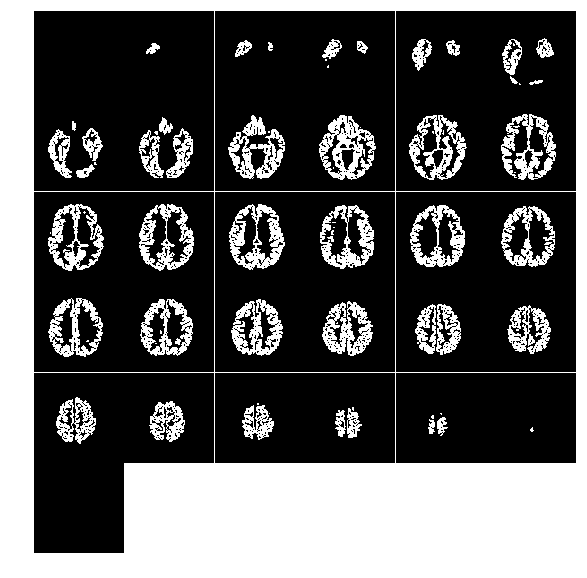

In [83]:
# Plot mask mosaic
import cortex
f = figure(figsize=(10,10))
cortex.mosaic(mask, cmap=cm.gray, interpolation="nearest");

### Visualizing the responses of a few voxels over time
Next you will visualize the responses of a few selected voxels over time. I selected these particular voxels because they are reasonably well explained by the semantic model, but have some differences in their responses across time.

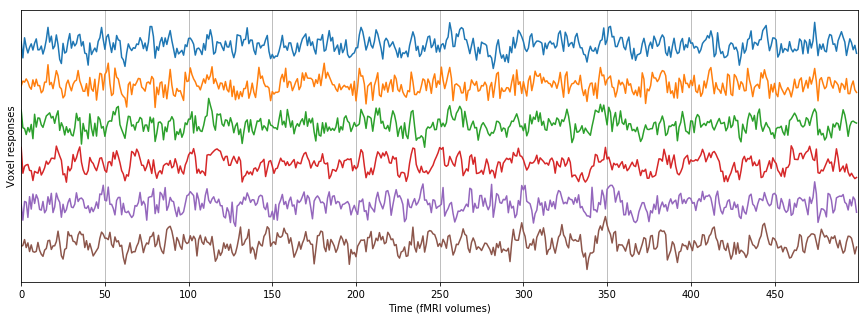

In [44]:
# Plot the response of a few voxels over time
selvoxels = [20710, 27627, 24344, 34808, 22423, 25397]

f = figure(figsize=(15, 5))
ax = f.add_subplot(1,1,1)
for ii,vi in enumerate(selvoxels):
    ax.plot(zRresp[:500, vi] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Voxel responses")
ax.grid()

## Regression model
Finally, the core of the analysis: you will fit a regression model that predicts the responses of each voxel as a weighted sum of the semantic features. This model will then be tested using a held out dataset (the Prediction dataset). And if the model proves to be reasonably predictive, then the weights of the regression model will tell us what semantic features each voxel responds to.

This is a linear regression model, so if the response time course for voxel $j$ is $R_j$, the stimulus time course for semantic feature $i$ is $S_i$, and the regression weight for feature $i$ in voxel $j$ is $\beta_{ij}$, then the model can be written as:

$$\hat{R}_j = \beta_{0j} S_0 + \beta_{1j} S_1 + \cdots$$

or:

$$\hat{R}_j = \sum_i \beta_{ij} S_i$$

The trick, of course, is accurately estimating the $\beta_j$ values. This is commonly done by minimizing the sum of the squared error (here across time, $t$):

$$E_j(\beta) = \sum_t (R_{jt} - \hat{R}_{jt})^2 = \sum_t (R_{jt} - \sum_i \beta_{i} S_{it})^2$$

$$\beta_j = \underset{\beta}{\operatorname{argmin}} E_j(\beta)$$

Computing $\beta$ this way is called ordinary least squares (OLS), and this will not work in our case because the total number of features (3940) is smaller than the number of time points (3737). (It would be possible if the number of delays was smaller than 4, but it would give terrible results.. feel free to try it! OLS can be performed using the function `np.linalg.lstsq`.)

In almost every case, linear regression can be improved by making some prior assumptions about the weights (or, equivalently, about the covariance structure of the stimuli). This is called **regularization**, or **regularized linear regression**. One way to do this is to penalize the error function by the sum of the squared weights. This is commonly known as **ridge regression**, and is a special case of [Tikhonov regularization](http://en.wikipedia.org/wiki/Ridge_regression). It finds the $\beta$ that minimizes the following error function:

$$E_j(\beta) = \sum_t (R_{jt} - \sum_i \beta_{i} S_{it})^2 + \alpha \sum_i \beta_i^2$$

(In practice we will use a different formulation that involves re-weighting the singular values of the matrix $S$ before computing its pseudoinverse. This method achieves the same results but is extremely efficient because it uses all the linear algebra machinery that computers are so good at to build many models in parallel.)

### The hyperparameter: $\alpha$
You may have noticed in the equation above that we have introduced a new parameter, $\alpha$, which controls the strength of the regularization. If $\alpha$ is set to zero, then we get back to exactly the OLS formulation (above). As $\alpha$ goes to infinity, the regularization forces all the weights to go to zero (in practice this also has the slightly weirder effect of making all the weights independent, as if each feature was regressed separately on the responses).

So how do we choose $\alpha$? We're going to do it here using cross-validation. First, we split the Regression dataset up into two parts. Then we estimate the weights for a given $\alpha$ on the first part, and test how well we can predict responses on the second part. This is repeated for each possible $\alpha$ that we want to test, and for a couple different splits of the Regression dataset. Then we find the $\alpha^*$ that gave us the best predictions within the split Regression dataset. Finally we estimate the weights using the entire Regression dataset and the selected $\alpha^*$.

Because this is an annoying and laborious process, I've encapsulated it within the function `bootstrap_ridge`. You simply give this function your datasets, the possible $\alpha$ values, and a few parameters for the cross-validation, and it does all the rest. The parameter `nboots` determines the number of cross-validation tests that will be run. 

To do cross-validation, `bootstrap_ridge` divides the Regression dataset into many small chunks, and then splits those chunks into the two groups that will be used to estimate weights and test $\alpha$ values. This is better than just choosing individual time points because both the fMRI data and stimuli are autocorrelated (i.e. correlated across time). The parameter `chunklen` determines the length of the chunks, and the parameter `nchunks` determines the number of chunks in the $\alpha$-testing dataset. By default I set `chunklen` to 40 time points (80-second chunks), and set `nchunks` to 20 (40 * 20 = 800 time points for testing $\alpha$ values, 3737-800 = 2937 time points for estimating weights). These values should not matter too much.

Running the regression will take a few minutes.

In [45]:
# Run regression
from ridge import bootstrap_ridge
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, zRresp, delPstim, zPresp,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)


INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 2937))
INFO:ridge_corr:Training stimulus has Frobenius norm: 1310.254
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.03231, max corr=0.26372, over-under(0.20)=18
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03636, max corr=0.27560, over-under(0.20)=60
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.04107, max corr=0.29628, over-under(0.20)=178
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.04710, max corr=0.33065, over-under(0.20)=411
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.05319, max corr=0.35023, over-under(0.20)=705
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.05717, max corr=0.36834, over-under(0.20)=913
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.05798, max corr=0.37614, over-under(0.20)=902
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.05566, max corr=0.37336, over-under(0.20)=759
INFO

In [66]:
delRstim.shape

(3737, 3940)

In [62]:
wt.shape

(3940, 37226)

DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXNonUnicode:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXNonUnicode ('/usr/local/lib/python3.6/site-packages/matplo

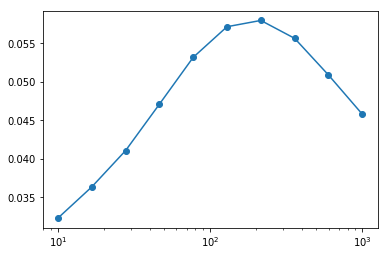

In [46]:
f = figure()
ax = f.add_subplot(1,1,1)
ax.semilogx( np.logspace(1, 3, 10), bscorrs.mean(2).mean(1), 'o-')

### Variables returned by the regression
Next let's have a look at the variables returned by the regression function.

In [47]:
# wt is the regression weights
print ("wt has shape: ", wt.shape)

# corr is the correlation between predicted and actual voxel responses in the Prediction dataset
print ("corr has shape: ", corr.shape)

# alphas is the selected alpha value for each voxel, here it should be the same across voxels
print ("alphas has shape: ", alphas.shape)

# bscorrs is the correlation between predicted and actual voxel responses for each round of cross-validation
# within the Regression dataset
print ("bscorrs has shape (num alphas, num voxels, nboots): ", bscorrs.shape)

# valinds is the indices of the time points in the Regression dataset that were used for each
# round of cross-validation
print ("valinds has shape: ", np.array(valinds).shape)

wt has shape:  (3940, 37226)
corr has shape:  (37226,)
alphas has shape:  (37226,)
bscorrs has shape (num alphas, num voxels, nboots):  (10, 37226, 1)
valinds has shape:  (1, 800)


### Testing the regression models by predicting responses
The `bootstrap_ridge` function already computed predictions and correlations for the Prediction dataset, but this is important so let's reproduce that step more explicitly.

Remember that according to the linear model, the predicted responses for each voxel are a weighted sum of the semantic features. An easy way to compute that is by taking the dot product between the weights and semantic features: $$\hat{R} = S \beta$$

In [48]:
# Predict responses in the Prediction dataset

# First let's refresh ourselves on the shapes of these matrices
print ("zPresp has shape: ", zPresp.shape)
print ("wt has shape: ", wt.shape)
print ("delPstim has shape: ", delPstim.shape)

zPresp has shape:  (291, 37226)
wt has shape:  (3940, 37226)
delPstim has shape:  (291, 3940)


In [49]:
# Then let's predict responses by taking the dot product of the weights and stim
pred = np.dot(delPstim, wt)

print ("pred has shape: ", pred.shape)

pred has shape:  (291, 37226)


#### Visualizing predicted and actual responses
Next let's plot some predicted and actual responses side by side.

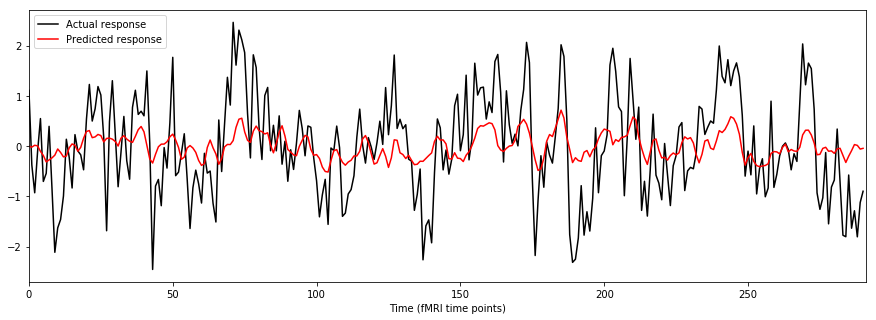

In [63]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a decent voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(pred[:,selvox], 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response"));

In [65]:
wt.shape

(3940, 37226)

#### Visualizing predicted and actual responses cont'd
You might notice above that the predicted and actual responses look pretty different scale-wise, although the patterns of ups and downs are vaguely similar. But we don't really care about the scale -- for fMRI it's relatively arbitrary anyway, so let's rescale them both to have unit standard deviation and re-plot.

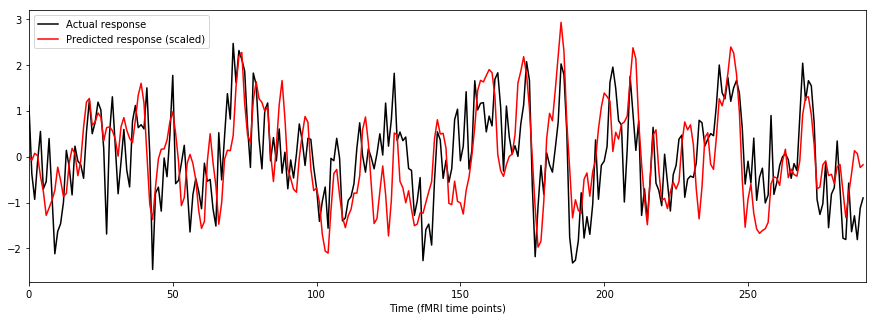

In [51]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a good voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(zscore(pred[:,selvox]), 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response (scaled)"));

Now you see that the actual and scaled predicted responses look very similar. We can quantify this similarity by computing the correlation between the two (correlation is scale-free, so it effectively automatically does the re-scaling that we did here). This voxel has high correlation.

In [52]:
# Compute correlation between single predicted and actual response
# (np.corrcoef returns a correlation matrix; pull out the element [0,1] to get 
# correlation between the two vectors)
voxcorr = np.corrcoef(zPresp[:,selvox], pred[:,selvox])[0,1]
print ("Correlation between predicted and actual responses for voxel %d: %f" % (selvox, voxcorr))

Correlation between predicted and actual responses for voxel 20710: 0.593783


#### Computing correlations for all voxels
Next let's compute this correlation for every voxel in the dataset. There are some very efficient ways to do this, but here I've written a for loop so that it's very explicit what's happening. (This should give exactly the same values as the variable `corr`, which was returned by `bootstrap_ridge`.)

In [53]:
voxcorrs = np.zeros((zPresp.shape[1],)) # create zero-filled array to hold correlations
for vi in range(zPresp.shape[1]):
    voxcorrs[vi] = np.corrcoef(zPresp[:,vi], pred[:,vi])[0,1]
print (voxcorrs)

[ 0.05682109 -0.02634303 -0.03431781 ... -0.08442223  0.08456757
 -0.04400821]


### Visualizing correlations across the brain
Let's start with a supposition: the correlation should not be high everywhere, even if this is a good model of how the brain represents the semantic content of speech. There are parts of the brain that just don't respond to speech, so the correlation should be low in those areas. There are other parts of the brain that respond to speech, but maybe don't represent semantic information, so the correlation should be low in those areas as well.

But let's begin by plotting a histogram of the correlations across the entire brain. This will show generally whether the model is working well or not.

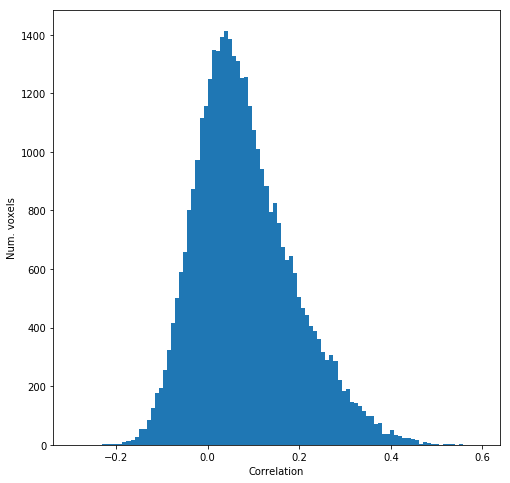

In [54]:
# Plot histogram of correlations
f = figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.hist(voxcorrs, 100) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels");

If the semantic features didn't capture anything about brain activity, then we would expect the histogram to be symmetric and centered around zero. But here we see that it's highly skewed, with lots of positive values. This looks good! This model is working!

Next, let's plot a mosaic of the correlations across the brain, as we plotted the mask earlier.

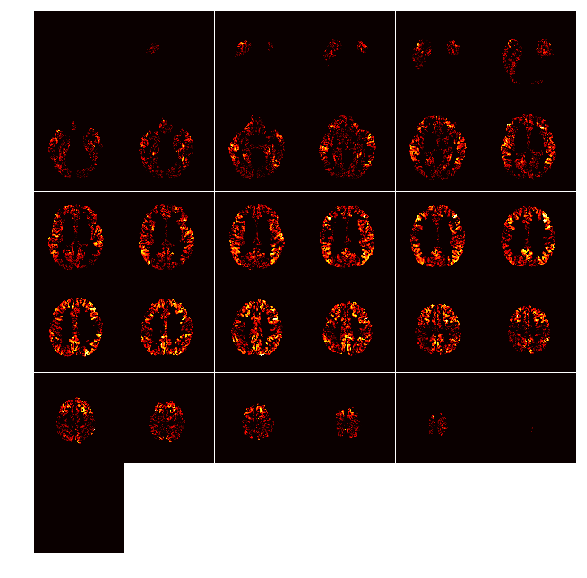

In [82]:
# Plot mosaic of correlations
corrvolume = np.zeros(mask.shape)
corrvolume[mask>0] = voxcorrs

f = figure(figsize=(10,10))
cortex.mosaic(corrvolume, vmin=0, vmax=0.5, cmap=cm.hot);

#### 3D visualization of correlations
In the mosaic we can see that there seem to be some concentrated areas of high correlation. But it's hard to say where in the brain those areas are based on the mosaic. So next you're going to create a fancy 3D visualization of the correlations using pyCortex.

Once you've opened the viewer you'll be presented with a 3D view of the brain with colors showing the correlations. White outlines and labels show the locations of known brain areas (motor, somatosensory, visual, and some language areas). Drag around with your left mouse button to rotate the view, and the right mouse button to zoom in or out. 

By default you'll see a view of the cortex as it looks in reality: folded and convoluted. To better see parts of the brain that are hidden down in the folds, you can press "i" to see an inflated view (or drag the "Mix" slider at the bottom of the screen to the middle). This helps to see the data, but you will still need to rotate the brain to see all of it. To make the entire cortex visible at once, you can press "f" to see a flattened view. To create this view we cut the cortical surface at a few locations, and then flattened it out so that it can all be seen at once (but this introduces some distortions).

In [87]:
# Plot correlations on cortex
import cortex
corrvol = cortex.Volume(corr, "S1", "fullhead", mask=mask, vmin=0, vmax=0.5, cmap='hot')
cortex.webshow(corrvol, port=8889, open_browser=False)


Started server on port 8889


<WebApp(Thread-6, started 123145387708416)>

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/paxtonfitzpatrick/Documents/Dartmouth/Thesis/memory-dynamics/code/pycortex/cortex/webgl/serve.py", line 288, in run
    self.server.listen(self.port)
  File "/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/tornado/tcpserver.py", line 142, in listen
    sockets = bind_sockets(port, address=address)
  File "/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/tornado/netutil.py", line 197, in bind_sockets
    sock.bind(sockaddr)
OSError: [Errno 48] Address already in use



In [ ]:
# View 3D model
# You will need to change where it says SERVERIP below to the IP you are connected to
from IPython.display import HTML
HTML("<a target='_blank' href='http://127.0.0.1/:8889'>Click here for viewer</a>")

### Simpler view of the correlations
pyCortex also offers a simpler way to view the correlations. This method only shows the flat view, but can be embedded right here in the ipython notebook. This should look like the flat view in the 3D viewer.

In [ ]:
# Plot correlation flatmap
cortex.quickshow(corrvol, with_rois=False, with_labels=False);

## What semantic features are the voxels responding to?
Now that we have a working model, let's try to figure out what semantic features are making each voxel respond. One way to do this is to simulate how the voxel will respond to individual words, and then find the most preferred words for that voxel.

But first we have an issue to contend with: we have separate weights for each delay. We could look at the weights for each delay, but instead here you will average the weights across delays to get a single set of weights for the voxel.

In [70]:
# Undelay voxel weights (average across delays)
import operator
from functools import reduce
udwt = reduce(operator.add, np.split(wt/ndelays, ndelays))

In [73]:
np.save('../../data/brains/HuthModelWeights.npy', udwt)

In [71]:
udwt.shape

(985, 37226)

Next you will pick which voxel to visualize. Since many voxels are modeled poorly, we will pick from among the best modeled voxels.

In [74]:
# Sort voxels by correlation so that we can pick a good voxel
# This will sort voxels in decreasing order of correlation
corrsort = np.argsort(corr)[::-1]

In [75]:
# Define function that will print best words for a voxel
import pprint

def print_voxel_words(voxnum):
    # find_words_like_vec returns 10 words most correlated with the given vector, and the correlations
    voxwords = eng1000.find_words_like_vec(udwt[:,voxnum])
    print ("Best words for voxel %d (correlation %0.3f):" % (voxnum, voxcorrs[voxnum]))
    pprint.pprint(voxwords)

In [76]:
# Print best words for some voxels
print_voxel_words(corrsort[0]) # best voxel
print_voxel_words(corrsort[14]) # 15th best voxel

Best words for voxel 20710 (correlation 0.594):
[(0.42623273274355333, 'sheet'),
 (0.4225392452781915, 'edges'),
 (0.41171230226580496, 'diameter'),
 (0.41149193840277665, 'strips'),
 (0.41004825675722595, 'cardboard'),
 (0.4099238127158721, 'copper'),
 (0.4013363008711218, 'steel'),
 (0.4008018664965089, 'colored'),
 (0.40071918625730224, 'coloured'),
 (0.40049890051188247, 'leaf')]
Best words for voxel 21577 (correlation 0.489):
[(0.3800741341170801, 'innocent'),
 (0.369106972737559, 'victim'),
 (0.3616865775791474, 'murderer'),
 (0.3569127519547846, 'child'),
 (0.3554678197597675, 'murder'),
 (0.3490629790555609, 'life'),
 (0.3490290020567613, 'truth'),
 (0.3456650472970889, 'guilty'),
 (0.34416283878664705, 'indeed'),
 (0.3425441807199445, 'death')]


### That's it!
That's the semantic model! Since you made it this far, well done. If you're interested, you can go back and try changing some of the parameters and see how it affects the model. One easy parameter to change is the number of delays (or the delays themselves). Try using just one delay. Or try using 10 delays (that might be slow). You could also try pruning off some of the semantic features. How does the model work if you only use the first 100 semantic features?

Alternatively, you can try using a different type of feature to model the fMRI responses: phonemes. Below are some blocks of code that will create stimulus vectors representing the number of times each different phoneme is spoken. The phoneme model will predict some voxels much better than the semantic model, and some voxels worse.


## Optional: phoneme model
Another type of information that the brain extracts from speech is the phonemic content. The following blocks of code will extract phonemic features from the stimuli. Run this, and then go back and run the "Regression Model" block, above. You can compare the correlations of the semantic model and phoneme model to see which works best in each voxel.

You can also visualize the phoneme stimuli and model as you go, building on the code blocks used above.

In [ ]:
# Create phoneme histogram DataSequences
from dsutils import histogram_phonemes2, phonemes
phonemehistseqs = dict() # dictionary to hold phoneme histograms {story name : DataSequence}
for story in allstories:
    phonemehistseqs[story] = histogram_phonemes2(phonseqs[story])

In [ ]:
# Phonemes were labeled using the ARPABET. The labeled phonemes are listed here.
print (phonemes)

In [ ]:
# Downsample phoneme histograms
interptype = "lanczos"
window = 3

downsampled_phonemehistseqs = dict()
for story in allstories:
    downsampled_phonemehistseqs[story] = phonemehistseqs[story].chunksums(interptype, window=window)


In [ ]:
# Combine phoneme stimuli
trim = 5
phRstim = np.vstack([np.nan_to_num(zscore(downsampled_phonemehistseqs[story][5+trim:-trim])) for story in Rstories])
phPstim = np.vstack([np.nan_to_num(zscore(downsampled_phonemehistseqs[story][5+trim:-trim])) for story in Pstories])


In [ ]:
# Delay stimuli
ndelays = 4
delays = range(1, ndelays+1)

delRstim = make_delayed(phRstim, delays)
delPstim = make_delayed(phPstim, delays)

In [ ]:
# Now go back to "Regression Model" and run that to fit a phoneme-based model!

### 